# Event Rate Calculation

This example notebook shows how to calculate the final weight for each event and use it to compute the event rate against any desired event properties. Use this notebook as a base to do your final data analysis on event selection and showing the rates for the selected events.

In [1]:
from icecube import dataio, dataclasses, icetray, phys_services
from I3Tray import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', dpi=300)
import nuSQuIDS as nsq
import h5py as h5
from glob import glob
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

In [2]:
# initialize nuSQuiDSs stuff (no need to change this)

# get nuSQuIDS units
units = nsq.Const()

# load the flux models
fluxdir = '/data/p-one/llallement/dimuon_generator/PROPOSAL/eventrate/'

astro_f = fluxdir+'Astrophysical.h5'
atmos_f = fluxdir+'Atmospheric_Conventional.h5'
promp_f = fluxdir+'Atmospheric_Prompt.h5'

astro = nsq.nuSQUIDSAtm(astro_f)
atmos = nsq.nuSQUIDSAtm(atmos_f)
promp = nsq.nuSQUIDSAtm(promp_f)

In [3]:
# define the weight normalization factor

NFILES = 100 # number of files you are going to use for event rate calculation
EVENTS_PER_FILE = 10000 # number of events per file
TYPE_FACTOR = 0.5 # 0.5 if you have both neutrinos and antineutrinos in your total events
                  # 1.0 if you are only considering either neutrinos or antineutrinos in total events

# normalizing factor (no need to change this)
NORM = EVENTS_PER_FILE * NFILES * TYPE_FACTOR

In [4]:
# no need to change this
def convert_pdg_nsq(pdg):
    '''Convert PDG code into NSQ convention'''
    if pdg==12: # nuE
        return (0,0)
    elif pdg==-12: # nuEBar
        return (0,1)
    elif pdg==14: # nuMu
        return (1,0)
    elif pdg==-14: # nuMuBar
        return (1,1)
    elif pdg==16: # nuTau
        return (2,0)
    elif pdg==-16: # nuTauBar
        return (2,1)
    else:
        print (f"Unkown neutrino pdg type {pdg}")
        assert False
    return

In [5]:
# no need to change this
def compute_weight(neutrino, oneweight):
    '''Compute the final weight for the given event.
    Input: neutrino (I3Particle), 
        oneweight (OneWeight value for the event)
    Output: final event weight in Hz unit'''
    
    nuflav, nutype = convert_pdg_nsq(neutrino.pdg_encoding)
    astro_wt = astro.EvalFlavor(nuflav,
                             np.cos(neutrino.dir.zenith),
                             neutrino.energy*units.GeV,
                             nutype)
    atmos_wt = atmos.EvalFlavor(nuflav,
                             np.cos(neutrino.dir.zenith),
                             neutrino.energy*units.GeV,
                             nutype)
    promp_wt = promp.EvalFlavor(nuflav,
                             np.cos(neutrino.dir.zenith),
                             neutrino.energy*units.GeV,
                             nutype)
    flux_weight = astro_wt + atmos_wt + promp_wt
    
    return oneweight * flux_weight / NORM

In [6]:
# function that will be used in the other functions to extract data

def content_select_function(frame, properties, dictionary):
    # neutrino energy
    mctree = frame['I3MCTree']
    nu = mctree.primaries[0]
    
    # mu energy
    mu1 = mctree.get_daughters(nu.id)[0]
    mu2 = mctree.get_daughters(nu.id)[1]
    
    # asymmetry
    asymmetry = abs((mu1.energy - mu2.energy)) / (mu1.energy + mu2.energy)
    
    # opening angle
    theta_mu1 = mu1.dir.zenith
    phi_mu1 = mu1.dir.azimuth
    theta_mu2 = mu2.dir.zenith
    phi_mu2 = mu2.dir.azimuth
    
    x_mu1 = np.sin(theta_mu1) * np.cos(phi_mu1)
    y_mu1 = np.sin(theta_mu1) * np.sin(phi_mu1)
    z_mu1 = np.cos(theta_mu1)

    x_mu2 = np.sin(theta_mu2) * np.cos(phi_mu2)
    y_mu2 = np.sin(theta_mu2) * np.sin(phi_mu2)
    z_mu2 = np.cos(theta_mu2)

    dot_product = x_mu1 * x_mu2 + y_mu1 * y_mu2 + z_mu1 * z_mu2

    mag_mu1 = np.sqrt(x_mu1**2 + y_mu1**2 + z_mu1**2)
    mag_mu2 = np.sqrt(x_mu2**2 + y_mu2**2 + z_mu2**2)

    op_angle_rad = np.arccos(dot_product / (mag_mu1 * mag_mu2))
    op_angle = np.degrees(op_angle_rad)
    
    # track separation
    dprop = frame['DoubleTrackProperties']
    track_separation = dprop['SeparationMax']

    # track length
    track1_length = dprop['Track1SegmentLength']
    track2_length = dprop['Track2SegmentLength']
    
    # weight
    weightdict = frame['I3MCWeightDict']
    weight = compute_weight(nu, weightdict['OneWeight'])

    if 'NuEnergy' in properties:
        dictionary['NuEnergy'].append(nu.energy)
    if 'Mu1Energy' in properties:
        dictionary['Mu1Energy'].append(mu1.energy)
    if 'Mu2Energy' in properties:
        dictionary['Mu2Energy'].append(mu2.energy)
    if 'Asymmetry' in properties:
        dictionary['Asymmetry'].append(asymmetry)
    if 'OpAngle' in properties:
        dictionary['OpAngle'].append(op_angle)
    if 'TrackSep' in properties:
        dictionary['TrackSep'].append(track_separation)
    if 'Track1Length' in properties:
        dictionary['Track1Length'].append(track1_length)
    if 'Track2Length' in properties:
        dictionary['Track2Length'].append(track2_length)
    if 'Weight' in properties:
        dictionary['Weight'].append(weight)

In [7]:
# extract data for the first cut: minimum track segment > 200 m

def select_both_tracks(frame, properties):
    global mintrk_store_dict
    
    dprop = frame['DoubleTrackProperties']
    track1_length = dprop['Track1SegmentLength']
    track2_length = dprop['Track2SegmentLength']
    
    if min(track1_length, track2_length) >= 200:
        content_select_function(frame, properties, mintrk_store_dict)

In [8]:
# extract data for the second cut: maximum track segment > 200 m

def select_either_track(frame, properties):
    global maxtrk_store_dict
    
    dprop = frame['DoubleTrackProperties']
    track1_length = dprop['Track1SegmentLength']
    track2_length = dprop['Track2SegmentLength']
    
    if max(track1_length, track2_length) >= 200:
        content_select_function(frame, properties, maxtrk_store_dict)

In [12]:
# extract data for the third cut: highest track separation > 25 m & minimum track segment > 200 m

def select_separation(frame, properties):
    global minsep_store_dict
    
    dprop = frame['DoubleTrackProperties']
    track_separation = dprop['SeparationMax']
    track1_length = dprop['Track1SegmentLength']
    track2_length = dprop['Track2SegmentLength']
    
    if (max(track1_length, track2_length) >= 200 and track_separation >= 25):
        content_select_function(frame, properties, minsep_store_dict)

In [9]:
# extract data for the 2D distributions (uncut data)

def select_data_hist2d(frame, properties):
    global hist2d_store_dict
    
    # neutrino energy
    mctree = frame['I3MCTree']
    nu = mctree.primaries[0]
    
    # track separation
    dprop = frame['DoubleTrackProperties']
    track_separation = dprop['SeparationMax']

    # track length
    track1_length = dprop['Track1SegmentLength']
    track2_length = dprop['Track2SegmentLength']
    
    # weight
    weightdict = frame['I3MCWeightDict']
    weight = compute_weight(nu, weightdict['OneWeight'])

    if 'TrackSep' in properties:
        hist2d_store_dict['TrackSep'].append(track_separation)
    if 'Track1Length' in properties:
        hist2d_store_dict['Track1Length'].append(track1_length)
    if 'Track2Length' in properties:
        hist2d_store_dict['Track2Length'].append(track2_length)
    if 'Weight' in properties:
        hist2d_store_dict['Weight'].append(weight)

In [10]:
# get the .i3 files (change it get all the files you want)

i3filelist = []

for i in range(1, 101):
    random_seed = str(110000 + i)
    datapath = '/data/p-one/llallement/dimuon_generator/PROPOSAL/i3_track_files/' + random_seed + '_trackOutput.i3.gz'
    i3filelist.append(datapath)

In [15]:
# run the icetray for the cut properties

# property keys to extract
pkeys = ['NuEnergy', 'Mu1Energy', 'Mu2Energy', 'Asymmetry', 'OpAngle', 'TrackSep', 'Weight']

# define blank list for each property
mintrk_store_dict = {key:[] for key in pkeys}
maxtrk_store_dict = {key:[] for key in pkeys}
minsep_store_dict = {key:[] for key in pkeys}

# run the icetray
tray = I3Tray()
tray.AddModule('I3Reader', 'reader',
              FilenameList = i3filelist)
tray.AddModule(select_both_tracks, 'both_tracks',
              properties = pkeys,
              Streams=[icetray.I3Frame.DAQ])
tray.AddModule(select_either_track, 'either_track',
              properties = pkeys,
              Streams=[icetray.I3Frame.DAQ])
tray.AddModule(select_separation, 'separation',
              properties = pkeys,
              Streams=[icetray.I3Frame.DAQ])
tray.Execute()

print('Number of events that made')
print('- the 1st cut: ' + str(len(mintrk_store_dict['NuEnergy'])))
print('- the 2nd cut: ' + str(len(maxtrk_store_dict['NuEnergy'])))
print('- the 3rd cut: ' + str(len(minsep_store_dict['NuEnergy'])))

Number of events that made
- the 1st cut: 1105
- the 2nd cut: 4109
- the 3rd cut: 53


In [16]:
# run the icetray for the uncut properties

pkeys_hist2d = ['TrackSep', 'Track1Length', 'Track2Length', 'Weight', 'TrackMin', 'TrackMax']
hist2d_store_dict = {key:[] for key in pkeys_hist2d}

tray = I3Tray()
tray.AddModule('I3Reader', 'reader',
              FilenameList = i3filelist)

tray.AddModule(select_data_hist2d, 'data_hist2d',
              properties = pkeys_hist2d,
              Streams=[icetray.I3Frame.DAQ])
tray.Execute()

print('Total number of events: ' + str(len(hist2d_store_dict['TrackSep'])))

Total number of events: 990733


In [17]:
# colors to be used in the graphs

default_colors = mcolors.TABLEAU_COLORS
lighter_colors = {name: mcolors.to_rgba(color, alpha=0.5) for name, color in default_colors.items()}

In [18]:
# compute the standard deviation on the event rate

def compute_std_event_rate(dictionary, x_value, ebins):
    n, binedges = np.histogram(dictionary[x_value], bins=ebins,
                               weights=dictionary['Weight'])
    var, _ = np.histogram(dictionary[x_value], bins=ebins,
                          weights=np.array(dictionary['Weight'])**2)
    
    err_low = np.array(n - np.sqrt(var))
    err_high = np.array(n + np.sqrt(var))
    
    return err_low, err_high, binedges

In [19]:
# compute the standard deviation of the expected events in 10 years

def compute_std_ten_years(dictionary, x_value, ebins):
    TIME = 10*365*24*60*60
    
    n, binedges = np.histogram(dictionary[x_value], bins=ebins,
                               weights=np.array(dictionary['Weight'])*TIME)
    var, _ = np.histogram(dictionary[x_value], bins=ebins,
                          weights=(np.array(dictionary['Weight'])*TIME)**2)
    
    err_low = np.array(n - np.sqrt(var))
    err_high = np.array(n + np.sqrt(var))
    
    return err_low, err_high, binedges

In [21]:
# plot event rate vs. some property for the three cuts

def plot_event_rate(ebins, x_value, x_label, x_title,
                    bool_log, save_plot):
    plt.figure()
    
    # both tracks
    both_tracks = plt.hist(mintrk_store_dict[x_value],
             bins=ebins,
             weights=mintrk_store_dict['Weight'],
             histtype='step',
             linestyle='--',
             lw=2,
             color=default_colors['tab:blue'],
             zorder=3,
             label='Min segment > 200 m')

    '''# to add error bars
    mintrk_err_low, mintrk_err_high, mintrk_binedges = compute_std_event_rate(mintrk_store_dict,
                                                                              x_value, ebins)
    
    plt.stairs(mintrk_err_high, edges=mintrk_binedges,
               baseline=mintrk_err_low, fill=True,
               facecolor=lighter_colors['tab:blue'])'''
    
    # either track
    either_track = plt.hist(maxtrk_store_dict[x_value],
             bins=ebins,
             weights=maxtrk_store_dict['Weight'],
             histtype='step',
             linestyle='-',
             lw=2,
             color=default_colors['tab:orange'],
             zorder=2,
             label='Max segment > 200 m')
    
    '''# to add error bars
    maxtrk_err_low, maxtrk_err_high, maxtrk_binedges = compute_std_event_rate(maxtrk_store_dict,
                                                                              x_value, ebins)
    
    plt.stairs(maxtrk_err_high, edges=maxtrk_binedges,
               baseline=maxtrk_err_low, fill=True,
               facecolor=lighter_colors['tab:orange'])'''
    
    # separation
    separation = plt.hist(minsep_store_dict[x_value],
             bins=ebins,
             weights=minsep_store_dict['Weight'],
             histtype='step',
             linestyle='-',
             lw=2,
             color=default_colors['tab:green'],
             zorder=1,
             label='Separation > 25 m')

    '''# to add error bars
    minsep_err_low, minsep_err_high, minsep_binedges = compute_std_event_rate(minsep_store_dict,
                                                                              x_value, ebins)

    plt.stairs(minsep_err_high, edges=minsep_binedges,
               baseline=minsep_err_low, fill=True,
               facecolor=lighter_colors['tab:green'])'''
        
    if bool_log == True: # log scale or not
        plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel('Event rate per bin (Hz)')
    title = 'Event rate vs. ' + x_title
    plt.title(title)
    plt.legend()
    save_title = 'plots_new/' + save_plot + '_rate.svg'
    plt.savefig(save_title, format='svg')
    plt.show();
    
    print('Event rate for')
    print('- the 1st cut: ' + str(np.sum(both_tracks[0])))
    print('- the 2nd cut: ' + str(np.sum(either_track[0])))
    print('- the 3rd cut: ' + str(np.sum(separation[0])))

In [22]:
# plot expected events in 10 years vs. some property for the three cuts

def plot_ten_years(ebins, x_value, x_label, x_title,
                   bool_log, save_plot):
    plt.figure()
    
    TIME = 10*365*24*60*60
    
    # both tracks
    both_tracks = plt.hist(mintrk_store_dict[x_value],
             bins=ebins,
             weights=np.array(mintrk_store_dict['Weight'])*TIME,
             histtype='step',
             linestyle='--',
             lw=2,
             color=default_colors['tab:blue'],
             zorder=3,
             label='Min segment > 200 m')

    '''mintrk_err_low, mintrk_err_high, mintrk_binedges = compute_std_ten_years(mintrk_store_dict,
                                                                             x_value, ebins)
    
    plt.stairs(mintrk_err_high, edges=mintrk_binedges,
               baseline=mintrk_err_low, fill=True,
               facecolor=lighter_colors['tab:blue'])'''
    
    # either track
    either_track = plt.hist(maxtrk_store_dict[x_value],
             bins=ebins,
             weights=np.array(maxtrk_store_dict['Weight'])*TIME,
             histtype='step',
             linestyle='-',
             lw=2,
             color=default_colors['tab:orange'],
             zorder=2,
             label='Max segment > 200 m')
    
    '''maxtrk_err_low, maxtrk_err_high, maxtrk_binedges = compute_std_ten_years(maxtrk_store_dict,
                                                                             x_value, ebins)
    
    plt.stairs(maxtrk_err_high, edges=maxtrk_binedges,
               baseline=maxtrk_err_low, fill=True,
               facecolor=lighter_colors['tab:orange'])'''
    
    # separation
    separation = plt.hist(minsep_store_dict[x_value],
             bins=ebins,
             weights=np.array(minsep_store_dict['Weight'])*TIME,
             histtype='step',
             linestyle='-',
             lw=2,
             color=default_colors['tab:green'],
             zorder=1,
             label='Separation > 25 m')

    '''minsep_err_low, minsep_err_high, minsep_binedges = compute_std_ten_years(minsep_store_dict,
                                                                             x_value, ebins)

    plt.stairs(minsep_err_high, edges=minsep_binedges,
               baseline=minsep_err_low, fill=True,
               facecolor=lighter_colors['tab:green'])'''
        
    if bool_log == True:
        plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel('Expected events per bin (/10 years)')
    title = 'Expected events in 10 years vs. ' + x_title
    plt.title(title)
    plt.legend()
    save_title = 'plots_new/' + save_plot + '_10y.svg'
    plt.savefig(save_title, format='svg')
    plt.show()
    
    print('Expected events in 10 years for')
    print('- the 1st cut: ' + str(np.sum(both_tracks[0])))
    print('- the 2nd cut: ' + str(np.sum(either_track[0])))
    print('- the 3rd cut: ' + str(np.sum(separation[0])))

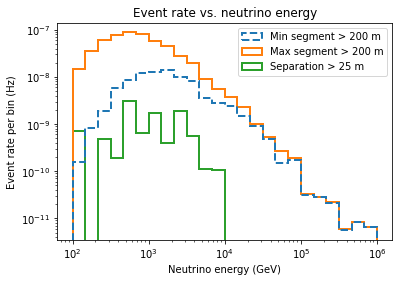

Event rate for
- the 1st cut: 8.648341689217908e-08
- the 2nd cut: 5.271436237383195e-07
- the 3rd cut: 9.838071356044664e-09


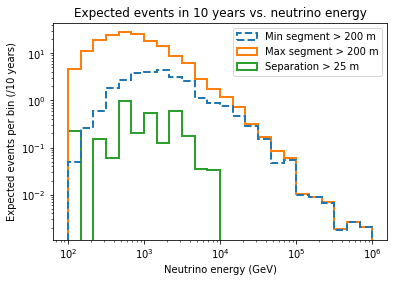

Expected events in 10 years for
- the 1st cut: 27.27341035111761
- the 2nd cut: 166.24001318211634
- the 3rd cut: 3.1025341828422444


In [23]:
# neutrino energy

bins1 = np.logspace(2, 6, 25)
plot_event_rate(bins1, 'NuEnergy', 'Neutrino energy (GeV)', 
                'neutrino energy', True, 'neutrino_energy')
plot_ten_years(bins1, 'NuEnergy', 'Neutrino energy (GeV)', 
               'neutrino energy', True, 'neutrino_energy')

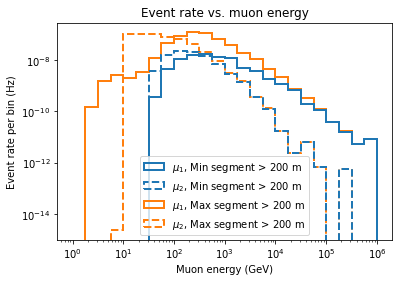

In [24]:
# muon energy (event rate)

ebins = np.logspace(0, 6, 25)

plt.hist(mintrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=mintrk_store_dict['Weight'],
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:blue',
         zorder=3,
         label=r'$\mu_1$, Min segment > 200 m')

plt.hist(mintrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=mintrk_store_dict['Weight'],
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:blue',
         zorder=4,
         label=r'$\mu_2$, Min segment > 200 m')

plt.hist(maxtrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=maxtrk_store_dict['Weight'],
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:orange',
         zorder=1,
         label=r'$\mu_1$, Max segment > 200 m')

plt.hist(maxtrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=maxtrk_store_dict['Weight'],
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:orange',
         zorder=2, 
         label=r'$\mu_2$, Max segment > 200 m')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon energy (GeV)')
plt.ylabel('Event rate per bin (Hz)')
plt.title('Event rate vs. muon energy')
plt.legend()
plt.savefig('plots/muon_energy_tot_rate.svg', format='svg')
plt.show();

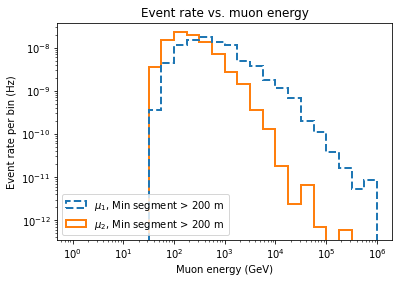

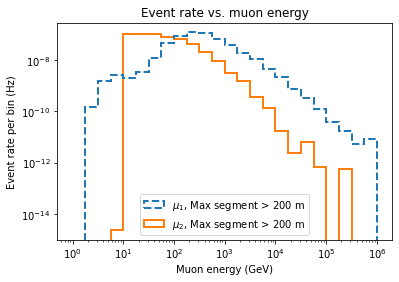

In [25]:
plt.hist(mintrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=mintrk_store_dict['Weight'],
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:blue',
         zorder=2,
         label=r'$\mu_1$, Min segment > 200 m')

plt.hist(mintrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=mintrk_store_dict['Weight'],
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:orange',
         zorder=1,
         label=r'$\mu_2$, Min segment > 200 m')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon energy (GeV)')
plt.ylabel('Event rate per bin (Hz)')
plt.title('Event rate vs. muon energy')
plt.legend()
plt.savefig('plots/muon_energy_min_rate.svg', format='svg')
plt.show();

plt.figure()

plt.hist(maxtrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=maxtrk_store_dict['Weight'],
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:blue',
         zorder=2,
         label=r'$\mu_1$, Max segment > 200 m')

plt.hist(maxtrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=maxtrk_store_dict['Weight'],
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:orange',
         zorder=1, 
         label=r'$\mu_2$, Max segment > 200 m')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon energy (GeV)')
plt.ylabel('Event rate per bin (Hz)')
plt.title('Event rate vs. muon energy')
plt.legend()
plt.savefig('plots/muon_energy_max_rate.svg', format='svg')
plt.show();

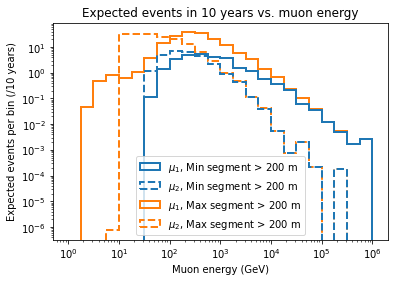

In [26]:
# muon energy (10 years)

ebins = np.logspace(0, 6, 25)

TIME = 10*365*24*60*60

plt.hist(mintrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=np.array(mintrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:blue',
         zorder=3,
         label=r'$\mu_1$, Min segment > 200 m')

plt.hist(mintrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=np.array(mintrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:blue',
         zorder=4,
         label=r'$\mu_2$, Min segment > 200 m')

plt.hist(maxtrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=np.array(maxtrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:orange',
         zorder=1,
         label=r'$\mu_1$, Max segment > 200 m')

plt.hist(maxtrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=np.array(maxtrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:orange',
         zorder=2, 
         label=r'$\mu_2$, Max segment > 200 m')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon energy (GeV)')
plt.ylabel('Expected events per bin (/10 years)')
plt.title('Expected events in 10 years vs. muon energy')
plt.legend()
plt.savefig('plots/muon_energy_tot_10y.svg', format='svg')
plt.show();

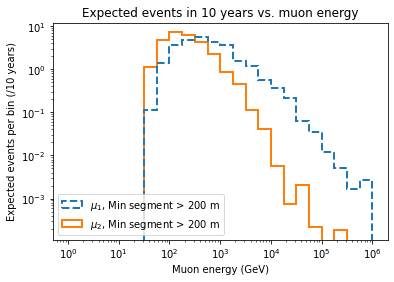

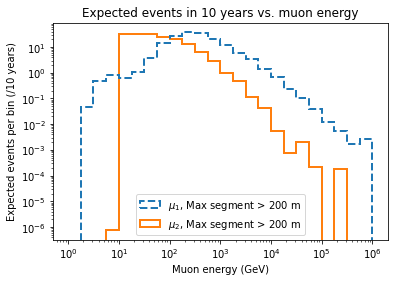

In [27]:
plt.hist(mintrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=np.array(mintrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:blue',
         zorder=2,
         label=r'$\mu_1$, Min segment > 200 m')

plt.hist(mintrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=np.array(mintrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:orange',
         zorder=1,
         label=r'$\mu_2$, Min segment > 200 m')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon energy (GeV)')
plt.ylabel('Expected events per bin (/10 years)')
plt.title('Expected events in 10 years vs. muon energy')
plt.legend()
plt.savefig('plots/muon_energy_min_10y.svg', format='svg')
plt.show();

plt.figure()

plt.hist(maxtrk_store_dict['Mu1Energy'],
         bins=ebins,
         weights=np.array(maxtrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='--',
         lw=2,
         color='tab:blue',
         zorder=2,
         label=r'$\mu_1$, Max segment > 200 m')

plt.hist(maxtrk_store_dict['Mu2Energy'],
         bins=ebins,
         weights=np.array(maxtrk_store_dict['Weight'])*TIME,
         histtype='step',
         linestyle='-',
         lw=2,
         color='tab:orange',
         zorder=1, 
         label=r'$\mu_2$, Max segment > 200 m')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Muon energy (GeV)')
plt.ylabel('Expected events per bin (/10 years)')
plt.title('Expected events in 10 years vs. muon energy')
plt.legend()
plt.savefig('plots/muon_energy_max_10y.svg', format='svg')
plt.show();

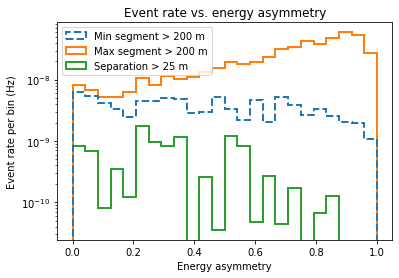

Event rate for
- the 1st cut: 8.648341689217914e-08
- the 2nd cut: 5.271436237383196e-07
- the 3rd cut: 9.838071356044661e-09


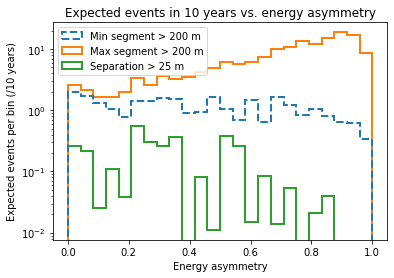

Expected events in 10 years for
- the 1st cut: 27.273410351117565
- the 2nd cut: 166.24001318211697
- the 3rd cut: 3.1025341828422444


In [28]:
# asymmetry

bins4 = np.linspace(0, 1, 25)
plot_event_rate(bins4, 'Asymmetry', 'Energy asymmetry', 
                'energy asymmetry', False, 'asymmetry')
plot_ten_years(bins4, 'Asymmetry', 'Energy asymmetry', 
                'energy asymmetry', False, 'asymmetry')

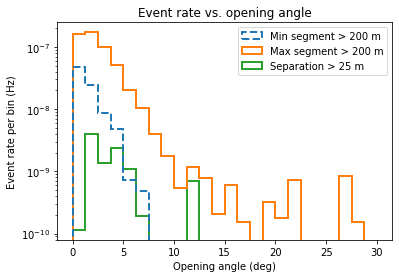

Event rate for
- the 1st cut: 8.64834168921792e-08
- the 2nd cut: 5.271436237383191e-07
- the 3rd cut: 9.838071356044661e-09


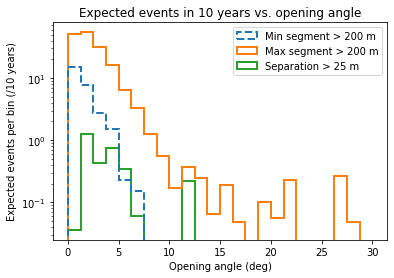

Expected events in 10 years for
- the 1st cut: 27.273410351117622
- the 2nd cut: 166.2400131821169
- the 3rd cut: 3.1025341828422444


In [29]:
# opening angle

bins5 = np.linspace(0, 30, 25)
plot_event_rate(bins5, 'OpAngle', 'Opening angle (deg)', 
                'opening angle', False, 'op_angle')
plot_ten_years(bins5, 'OpAngle', 'Opening angle (deg)', 
                'opening angle', False, 'op_angle')

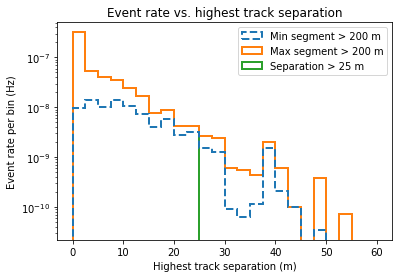

Event rate for
- the 1st cut: 8.648341689217903e-08
- the 2nd cut: 5.271436237383198e-07
- the 3rd cut: 9.838071356044661e-09


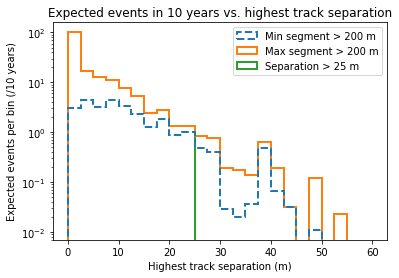

Expected events in 10 years for
- the 1st cut: 27.27341035111764
- the 2nd cut: 166.24001318211668
- the 3rd cut: 3.102534182842244


In [30]:
# track separation

bins6 = np.linspace(0, 60, 25)
plot_event_rate(bins6, 'TrackSep', 'Highest track separation (m)', 
                'highest track separation', False, 'track_sep')
plot_ten_years(bins6, 'TrackSep', 'Highest track separation (m)', 
                'highest track separation', False, 'track_sep')

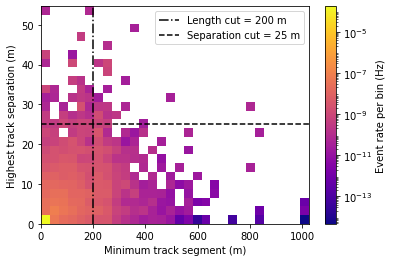

In [32]:
# 2d histogram (minimum segment)

track1_length = np.array(hist2d_store_dict['Track1Length'])
track2_length = np.array(hist2d_store_dict['Track2Length'])

min_track_length = np.minimum(track1_length, track2_length)
hist2d_store_dict['TrackMin'] = min_track_length.tolist()

plt.figure()

plt.hist2d(hist2d_store_dict['TrackMin'],
           hist2d_store_dict['TrackSep'],
           bins=[30, 25],
           weights=hist2d_store_dict['Weight'],
           cmap='plasma',
           norm=mcolors.LogNorm())

cbar = plt.colorbar(label='Event rate per bin (Hz)')

cbar.ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100))

def format_major_label(x, pos):
    return r'$10^{%d}$' % np.log10(x)

cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_major_label))

plt.axvline(200, color='black', linestyle='-.', label='Length cut = 200 m')
plt.axhline(25, color='black', linestyle='--', label='Separation cut = 25 m')

plt.xlabel('Minimum track segment (m)')
plt.ylabel('Highest track separation (m)')
plt.legend()
plt.savefig('plots/hist2d_min_rate.svg', format='svg')
plt.show();

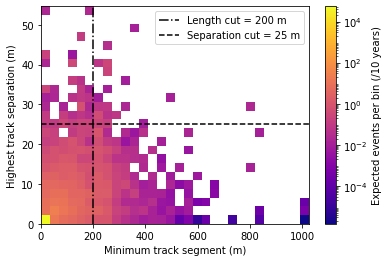

In [33]:
TIME = 10*365*24*60*60

track1_length = np.array(hist2d_store_dict['Track1Length'])
track2_length = np.array(hist2d_store_dict['Track2Length'])

min_track_length = np.minimum(track1_length, track2_length)
hist2d_store_dict['TrackMin'] = min_track_length.tolist()

plt.figure()

plt.hist2d(hist2d_store_dict['TrackMin'],
           hist2d_store_dict['TrackSep'],
           bins=[30, 25],
           weights=np.array(hist2d_store_dict['Weight'])*TIME,
           cmap='plasma',
           norm=mcolors.LogNorm())

cbar = plt.colorbar(label='Expected events per bin (/10 years)')

cbar.ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100))

def format_major_label(x, pos):
    return r'$10^{%d}$' % np.log10(x)

cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_major_label))

plt.axvline(200, color='black', linestyle='-.', label='Length cut = 200 m')
plt.axhline(25, color='black', linestyle='--', label='Separation cut = 25 m')

plt.xlabel('Minimum track segment (m)')
plt.ylabel('Highest track separation (m)')
plt.legend()
plt.savefig('plots_new/hist2d_min_10y.svg', format='svg')
plt.show();

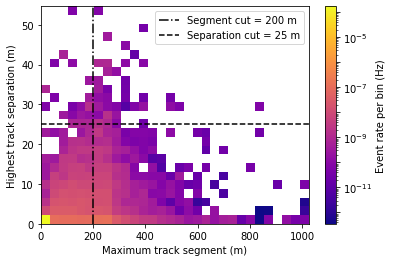

In [34]:
# 2d histogram (maximum segment)

track1_length = np.array(hist2d_store_dict['Track1Length'])
track2_length = np.array(hist2d_store_dict['Track2Length'])

max_track_length = np.maximum(track1_length, track2_length)
hist2d_store_dict['TrackMax'] = max_track_length.tolist()

plt.hist2d(hist2d_store_dict['TrackMax'],
           hist2d_store_dict['TrackSep'],
           bins=[30, 25],
           weights=hist2d_store_dict['Weight'],
           cmap='plasma',
           norm=mcolors.LogNorm())

cbar = plt.colorbar(label='Event rate per bin (Hz)')

cbar.ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100))

def format_major_label(x, pos):
    if pos % 2 != 0:
        return f'$10^{{{int(np.log10(x))}}}$'
    else:
        return ''

cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_major_label))

plt.axvline(200, color='black', linestyle='-.', label='Segment cut = 200 m')
plt.axhline(25, color='black', linestyle='--', label='Separation cut = 25 m')

plt.xlabel('Maximum track segment (m)')
plt.ylabel('Highest track separation (m)')
plt.legend()
plt.savefig('plots_new/hist2d_max_rate.svg', format='svg')
plt.show();

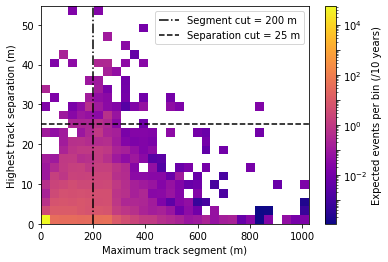

In [35]:
track1_length = np.array(hist2d_store_dict['Track1Length'])
track2_length = np.array(hist2d_store_dict['Track2Length'])

max_track_length = np.maximum(track1_length, track2_length)
hist2d_store_dict['TrackMax'] = max_track_length.tolist()

hist = plt.hist2d(hist2d_store_dict['TrackMax'],
           hist2d_store_dict['TrackSep'],
           bins=[30, 25],
           weights=np.array(hist2d_store_dict['Weight'])*TIME,
           cmap='plasma',
           norm=mcolors.LogNorm())

cbar = plt.colorbar(label='Expected events per bin (/10 years)')

cbar.ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=100))

def format_major_label(x, pos):
    if pos % 2 != 0:
        return f'$10^{{{int(np.log10(x))}}}$'
    else:
        return ''

cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_major_label))

plt.axvline(200, color='black', linestyle='-.', label='Segment cut = 200 m')
plt.axhline(25, color='black', linestyle='--', label='Separation cut = 25 m')

plt.xlabel('Maximum track segment (m)')
plt.ylabel('Highest track separation (m)')
plt.legend()
plt.savefig('plots_new/hist2d_max_10y.svg', format='svg')
plt.show();